# You're only as old as you feel

Using the awesome [Alchemy API](http://www.alchemyapi.com/api/face-detection/urls.html) facial recognition software, I decided to see if a computer can guess ages and gender, and see where me and some of my buddies rank next to faces of celebrities.  Alchemy's technology does all the "heavy-lifting", and makes it really easy to extract faces from image.  We'll focus on facial recognition, but Alchemy also privides natural language processing technology, such as tools to estimate how positive or negative a news article is (highly-level sentiment analysis).  If you want to follow along, you'll need these libraries in additional to the core [SciPy libraries (Numpy, matplotlib, IPython)](http://scipy.org/):

    AlchemyAPI (you need to request an API key before getting started)
    scikit-image
    pyparty (for some multiplot utilities)
        - https://github.com/hugadams/pyparty

Once caveat: My Alchemy has a [small hack to make FaceTagging available directly](https://github.com/AlchemyAPI/alchemyapi_python/pull/14) from the Python SDK.  You can clone my version for the time being: https://github.com/hugadams/alchemyapi_python

#### Load some peoples

I used facebook to track the URL to some pictures of my friends, with unobstructed views of their faces and seemingly good image quality.  Then I grabbed a bunch of group and individual pics of celebrities. 

In [1]:
%pylab inline
from __future__ import division
import skimage.io as skio
import os 

BUDDIES = dict(ADAM_PAM = 'https://fbcdn-sphotos-h-a.akamaihd.net/hphotos-ak-xap1/v/t1.0-9/10376166_822056220894_5561513357790421351_n.jpg?oh=9ebbb3689ed812bf382d44de9cc70cf3&oe=558EE0E2&__gda__=1431275407_c369c759180795f48f510934549726bc',
               CLAIRE = 'https://scontent.xx.fbcdn.net/hphotos-xap1/v/t1.0-9/972052_10151392945616852_2137233219_n.jpg?oh=1991c7b817049105d758adad1fa33977&oe=5553882C',
               LUCAS_FRENZ = 'https://fbcdn-sphotos-g-a.akamaihd.net/hphotos-ak-xpa1/v/t1.0-9/10420147_850089067844_7304615519059766508_n.jpg?oh=7dcc9c28ad6f08b3940b0fd6e6a3ca6e&oe=558B0F7D&__gda__=1435652352_f74757242f9ed9ac336102acb17ffa4e',
               SAMMI_TONY = 'https://scontent.xx.fbcdn.net/hphotos-xfp1/v/t1.0-9/10686867_10102938908690283_3719803132104144472_n.jpg?oh=053d7da50ff7d297393eef96505e8326&oe=558F7F0C',
               ZACH = 'https://fbcdn-sphotos-g-a.akamaihd.net/hphotos-ak-xpf1/v/t1.0-9/10994273_10102416274827895_3192037160183659148_n.jpg?oh=e82f5404c950996327a34e4cb28c6262&oe=554B6A89&__gda__=1431240182_548bded0dcddadca1ec7d1c5c5b0ca2b',
               LAURA_DARREN = 'https://scontent.xx.fbcdn.net/hphotos-xfp1/v/t1.0-9/10527273_10100171830791771_5473228770575944118_n.jpg?oh=5a823b31e5c197afd87a69aee57037b9&oe=554F2CB6',
               STEVE='https://media.licdn.com/mpr/mpr/shrinknp_200_200/p/7/000/234/0e0/383c171.jpg'
              )

CELEBS = dict(GOT_GALS = 'http://media4.popsugar-assets.com/files/2013/07/04/088/n/4981324/cdf19997323733ea_Main.xxxlarge/i/Pictures-Women-Game-Thrones-Emilia-Clarke.jpg',
              GOT_GUYS = 'http://media1.popsugar-assets.com/files/2014/06/13/959/n/1922283/462854365d4d1e3f_GoT-Cover.xxxlarge/i/Hottest-Guys-Game-Thrones.jpg',
              INKMASTER = 'http://www.slangstrong.com/wp-content/uploads/2012/11/Ink-Masters.jpg',
              FASTFIVEGUYS = 'http://thatsenuff.com/wp-content/uploads/2011/04/0429-rather-obvi-credit.jpg',
              MROD = 'http://d1oi7t5trwfj5d.cloudfront.net/81/3e/1e704c3c4232b7d10eaf67f8d260/michelle-rodriguez.jpg',
              EVA = 'http://media1.popsugar-assets.com/files/2013/01/02/3/192/1922398/d8a83663d4d95316_evamendes.xxxlarge_2.jpg',
              RYGOSLING = 'http://blogs.psychcentral.com/life-goals/files/2015/01/ryan-gosling.jpg',
              THE_CLOONE = 'http://img2-2.timeinc.net/people/i/2014/sandbox/news/140210/george-clooney-600x450.jpg',
              REAL_HOUSEWIVES = 'http://media.silive.com/entertainment_impact_tvfilm/photo/real-housewives-of-new-jerseyjpg-87e95765ec41dcc8.jpg'
              )
              
US_AND_THEM = dict(BUDDIES.items() + CELEBS.items())
              

def showimage(url_or_array, *args, **kwargs):
    """ Displays image; removes x/y labels"""
    ax = kwargs.pop('ax', pylab.gca())
    if isinstance(url_or_array, basestring):
        out = ax.imshow(skio.imread(url_or_array), *args, **kwargs)
    else:
        out = ax.imshow(url_or_array, *args, **kwargs)
    # Hide x and y axis ticks/labels
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    return out

Populating the interactive namespace from numpy and matplotlib


So for example, the pic of [me and my fiancee](http://registry.theknot.com/pamela-sachs-adam-hughes-september-2016-ny/10058171) looks like:

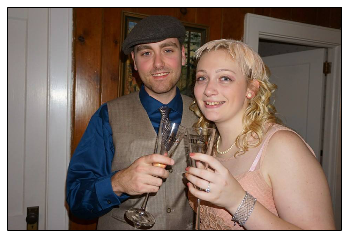

In [2]:
showimage(US_AND_THEM['ADAM_PAM']);

And for ink master:

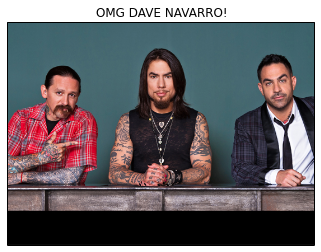

In [3]:
showimage(CELEBS['INKMASTER'])
plt.title("OMG DAVE NAVARRO!");

And so on

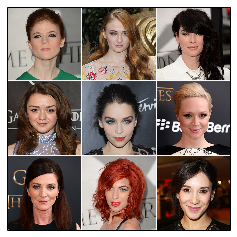

In [4]:
showimage(CELEBS['GOT_GALS']);

#### Face Finding

Next, I have to load Alchemy's Python SDK and then I can pass these images into the face recognition features.

In [5]:
os.chdir(os.path.expanduser('~/Desktop/alchemyapi_python/'))
from alchemyapi import AlchemyAPI

api = AlchemyAPI() #<-- Instantiate

We can use `AlchemyAPI.faceTagging` to find one or more faces in an image.

In [6]:
api.faceTagging('url', BUDDIES['ADAM_PAM'])

{u'imageFaces': [{u'age': {u'ageRange': u'18-24', u'score': u'0.502411'},
   u'gender': {u'gender': u'MALE', u'score': u'0.989013'},
   u'height': u'156',
   u'positionX': u'357',
   u'positionY': u'79',
   u'width': u'156'},
  {u'age': {u'ageRange': u'35-44', u'score': u'0.506266'},
   u'gender': {u'gender': u'FEMALE', u'score': u'0.992608'},
   u'height': u'172',
   u'positionX': u'511',
   u'positionY': u'146',
   u'width': u'172'}],
 u'status': u'OK',
 u'totalTransactions': u'4',
 u'url': u'https://fbcdn-sphotos-h-a.akamaihd.net/hphotos-ak-xap1/v/t1.0-9/10376166_822056220894_5561513357790421351_n.jpg?oh=9ebbb3689ed812bf382d44de9cc70cf3&oe=558EE0E2&__gda__=1431275407_c369c759180795f48f510934549726bc',
 u'usage': u'By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html'}

### Store the Faces Pythonically

Rather than work with these JSON streams, I'll build a class to store a face.  Some of the metatadata stored on the face will include:
     
     - Pixels in original image where face is
     - Reference to original image
     - Predicted gender and confidence score
     - Predicted ageRange and confidence score
     
The code below defines such a class.  If you're not a programmer, just overlook it.  These are being stored in a namedtuple for code brevity.

In [7]:
from collections import namedtuple

# Custom named tuple class, custom printout
Face = namedtuple('Face', ['face', 'index', 'gender', 'genderscore', 'agerange', 'agescore'], verbose=False)
def newrep(obj):
    return 'FACE_{o.index} ({o.gender} {o.genderscore}, {o.agerange} {o.agescore})'.format(o=obj)
Face.__repr__ = newrep

def cutface(image, facetag):
    """ Given original image and JSON face tag, crop out the face. """
    
    def _parseFace(attr):
        return int(facetag[attr])

    X, Y, WIDTH, HEIGHT = _parseFace('positionX'), _parseFace('positionY'), _parseFace('width'), _parseFace('height')
    return image[Y:Y+HEIGHT, X:X+WIDTH]

def mapfaces(facedict):
    """ Takes a dictionary of name:url (see BUDDIES above) and returns name:Face,
    where FACE is the python class for storing image face and metadata.
    """

    out = {}
    for name, imageurl in US_AND_THEM.items():
        try:
            faces = api.faceTagging('url', imageurl)['imageFaces']
        except Exception as exc:
            print "FAILED ON IMAGE: %s with exception:\n%s" % (name, exc.message)
            continue
        image = skio.imread(imageurl)
        out[name] = []
    
        # Iterate over faces, store
        for (idx, facetag) in enumerate(faces):
            faceregion = cutface(image, facetag)
            gender = facetag['gender']['gender']
            genderscore = float(facetag['gender']['score'])
            agerange = facetag['age']['ageRange']
            agescore = float(facetag['age']['score'])
            if agerange == '<18':
                agerange = '0-18' #<-- For sorting later on
            out[name].append(Face(faceregion, idx, gender, genderscore, agerange, agescore))
    return out
    
# THIS ACTUALLY DOES THE MAPPING
US_AND_THEM = mapfaces(US_AND_THEM)

Now the face regions of the image, as well as the important metadata', are stored in a list of `Face` classes.  The list is called `FACES`.  Some images have multiples faces, and we can access the face image from the `face` attribute.

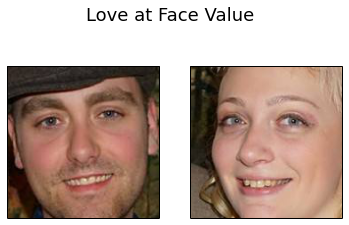

In [8]:
adam, pam = US_AND_THEM['ADAM_PAM']

f, (ax1, ax2) = plt.subplots(1,2)
showimage(adam.face, ax=ax1)
showimage(pam.face, ax=ax2)
f.suptitle('Love at Face Value', fontsize=18);

### Analytics

The Alchemy facial recognition algorithm predicts age range and gender.  It also gives a confidence score to these predictions.  How confident in the prediction of "MAN" is the algorithm?  We can split the list up by gender.  *I'm also going to import a `multi_axes` function from my `pyparty` library to make it easier to plot lots of faces (you will need pyparty to run this)*

In [9]:
from pyparty.utils import multi_axes

ALL = []
MEN = []
WOMEN = []
for faces in US_AND_THEM.values():
    for face in faces:
        ALL.append(face)
        if face.gender == 'MALE':
            MEN.append(face)
        else:
            WOMEN.append(face)
            
def multiface_plot(faces, title=''):
    """ From list of faces, plots each face, maintaining sort order
    and figures out sizing/number of subaxes to create automatically.
    """
    def rint(x): 
        return int(round(x))
   
    num = len(faces)
    
    # Ad-hoc stuff to ensure images sized right
    size=(5+rint(num/2), 2.5+rint(num/2))
    axes = multi_axes(num, figsize=size)[0]

    #Sort faces in each age group by confidence of age group
    for (idx, face) in enumerate(faces):
        try:
            ax = axes[idx]
        except TypeError:
            ax = axes #<--- IF length 1
        showimage(face.face, ax=ax)
        plt.tight_layout()
    f=plt.gcf()
    f.suptitle(title,
               fontsize=16,
               y=1.02)
    return f, axes


/home/adam/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/enthought/__init__.py:11: UserWarning: Module argparse was already imported from /home/adam/Canopy/appdata/canopy-1.4.0.1938.rh5-x86/lib/python2.7/argparse.pyc, but /home/adam/Enthought/Canopy_32bit/User/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


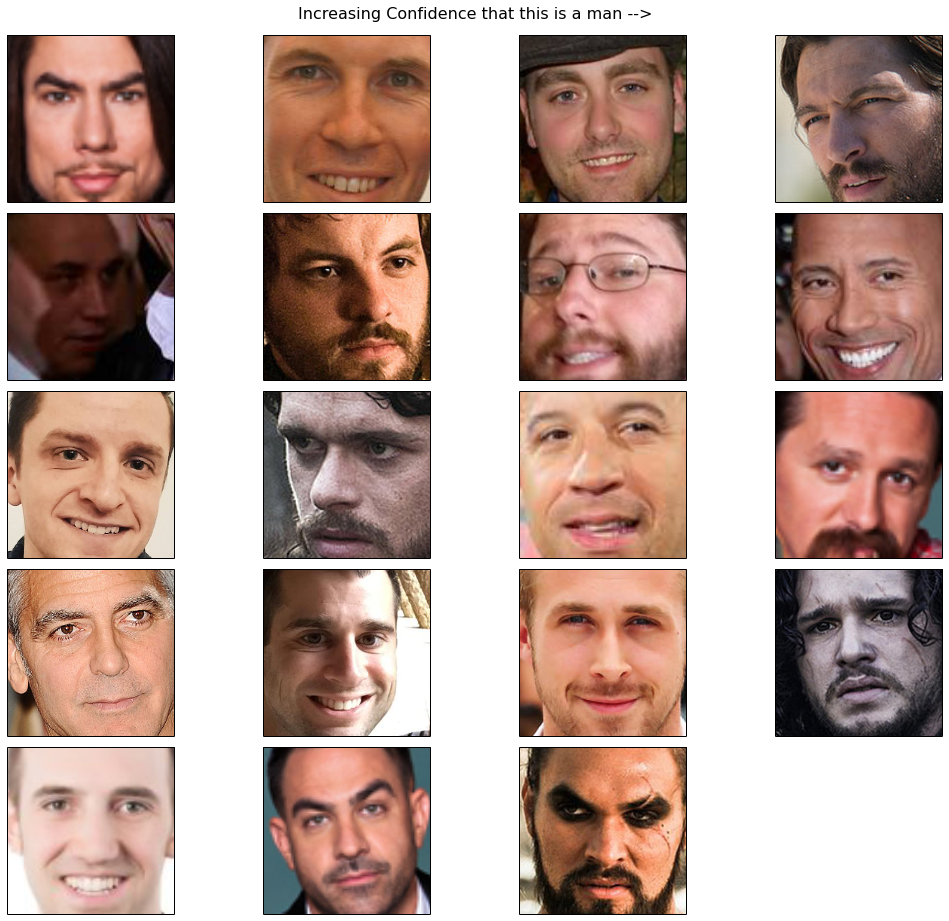

In [10]:
MALECERTAINTY = sorted(MEN, key=lambda x: x.genderscore)
multiface_plot(MALECERTAINTY, title='Increasing Confidence that this is a man -->');

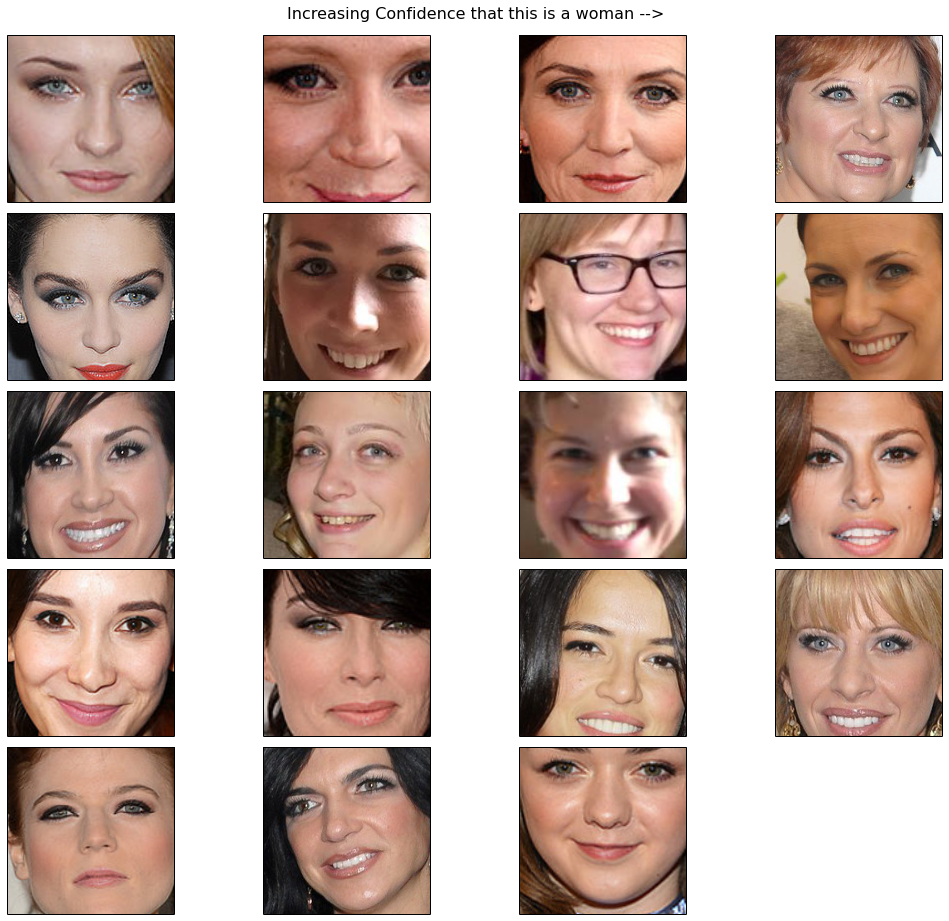

In [11]:
GALCERTAINTY = sorted(WOMEN, key=lambda x: x.genderscore)
multiface_plot(GALCERTAINTY, title='Increasing Confidence that this is a woman -->');

It's interesting that Massie William's character Arya Stark hid in plain sight as a boy in GOT season 2, considering she has been predicted female with highest certainty.

**But what does it mean to be more confident?**

Good question.  While we may naively presume it can be interpreted as "more manly", this is too simplistic.  In reality, the facial recognition classifier was trained on a finite set of images of known age and gender.  Therefore, whatever qualities were present in those images, as well as parameters of the algorithm itself, led to the quantification of confidence in age or gender.  The algorithm is likely to be biased towards features present in those images.  Therefore, an algorithm being more "confident" that Kit Harrington is a man than I am reflects that the algorithm see features in Kit more associated with men's faces than in mine.  Whether these features are indeed the natural features a humanbeing is hard to say.  But the fact that a computer can be trained to think this way is kind of astonishing. 

In regard to age, the same considerations apply.  In addition, the number of training images of each age group could be a factor in assignment and confidence.  For example, if there were more 35-44 year old images available at training time, perhaps the confidence in this age range are higher?  I really don't know, if someone wants to add to this, feel free.

### Age Prediction

In [12]:
#Get all age groups
agegroups = set([p.agerange for p in ALL])

#Group in dict
BY_AGE = dict((group,[]) for group in agegroups)
for face in ALL:
    BY_AGE[face.agerange].append(face)    

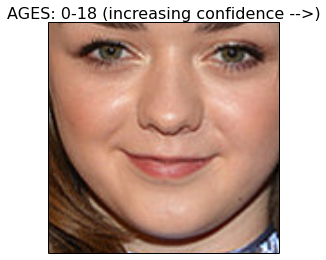

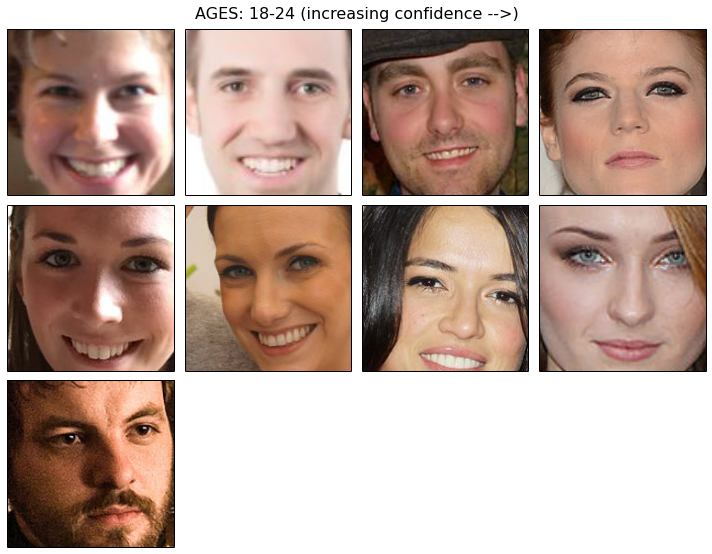

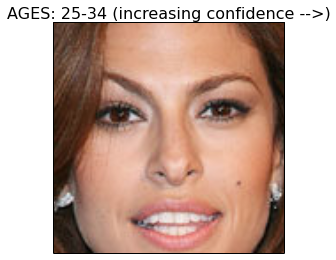

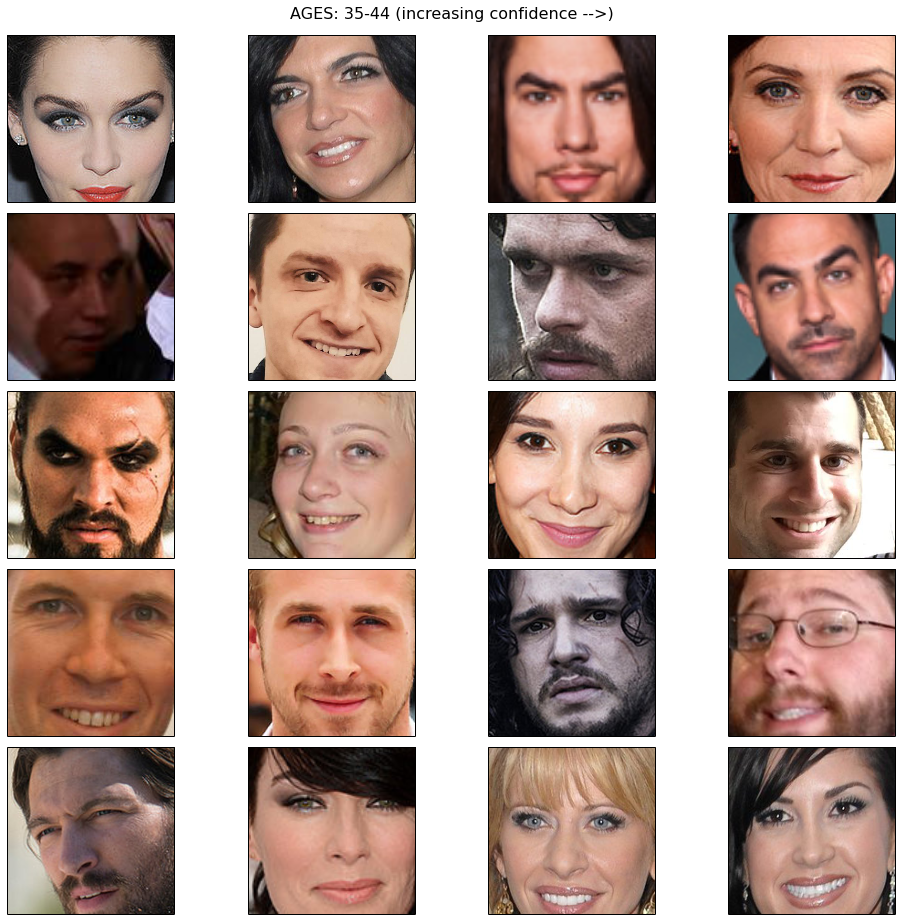

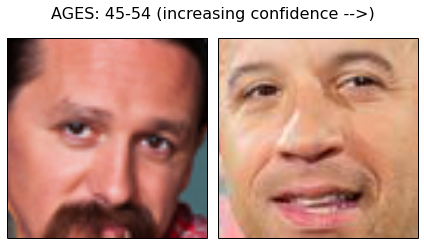

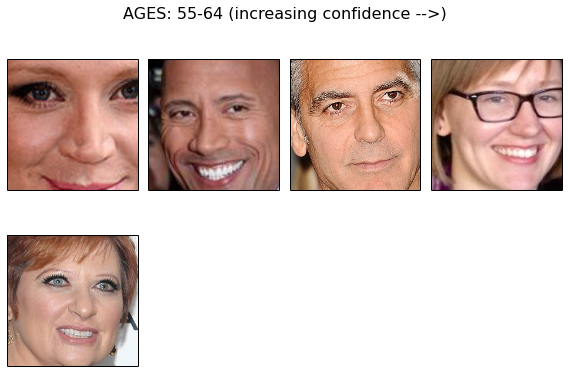

In [13]:
for group, faces in sorted(BY_AGE.items()):
    faces = sorted(faces, key=lambda x: x.agescore)
    multiface_plot(faces, title='AGES: %s (increasing confidence -->)'% group)

### Let's visualize the spread in confidence scores

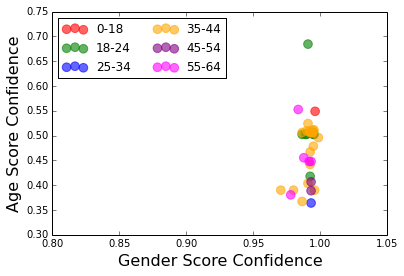

In [14]:
gscores = [f.genderscore for f in ALL]
ascores = [f.agescore for f in ALL]
ages = [f.agerange for f in ALL]

agecolors = ['r','g','b','orange','purple','magenta']

for (idx, (age, agegroup)) in enumerate(sorted(BY_AGE.items())):
    gscores = [f.genderscore for f in agegroup]
    ascores = [f.agescore for f in agegroup]
    plt.scatter(gscores, ascores, color=agecolors[idx], s=75, alpha=.6)
    
plt.legend(sorted(BY_AGE), loc='upper left', ncol=2);
plt.xlim(0.8,1.05)
plt.xlabel('Gender Score Confidence', fontsize=16)
plt.ylabel('Age Score Confidence', fontsize=16);

A couple interesting points:
   1. The prediction of gender is more confident than that of age.  This makes sense, since gender only has 2 categories, while age has 6. 
   2. There are two salient outliers: someone whose gender is less confidently predicted, and someone whose age is most confidently predicted.  Both of these folks are 18-24.  Who are these folks?  

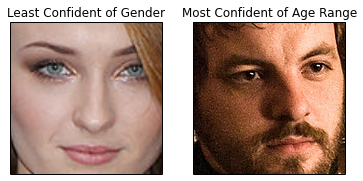

In [15]:
#Get face with lowest gender score
youngins = BY_AGE['18-24']
mingender = min(youngins, key=lambda x: x.genderscore).face
maxage = max(youngins, key=lambda x: x.agescore).face

f, (ax1, ax2) = plt.subplots(1,2)

showimage(mingender, ax=ax1)
showimage(maxage, ax=ax2)
ax1.set_title('Least Confident of Gender')
ax2.set_title('Most Confident of Age Range');

[Gethin Anthony](http://unitedagents.co.uk/gethin-anthony) is 31 by the way...

### What does this say about my age, gender?

In effect, nothing.  The point of this exercise was to show some new tools available to researchers, and just how accessible facial recognition has become.  Remember, we're using just a single picture for each person.  The variation in a face due to facial hair, expression, image quality etc... is probably drastic (I haven't tested it).  Not to mention, we know little about the training data, nor how the predictions are made.  This is not to say they are unreliable; rather, it's a black box so let's not get too invested in what the results "mean".  

<hr>
<br>


<div style="float:left; \">
    <img src="https://avatars0.githubusercontent.com/u/1972276?s=460" 
 align=left; text-align:center; style="float:left; margin-left: 5px; margin-top: -25px; width:150px; height:150px" /> 
</div>

<div style="float:left; \"><a href="https://github.com/hugadams">
    <img src="https://assets-cdn.github.com/images/modules/logos_page/GitHub-Mark.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>


<div style="float:left; \"><a href="https://twitter.com/hughesadam87">
    <img src="http://paymentmagnates.com/wp-content/uploads/2014/04/twitter-icon.png" 
 align=left; text-align:center; style="float:left; margin-left: 25px; margin-top: -25px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.researchgate.net/profile/Adam_Hughes2?ev=hdr_xprf">
    <img src="http://www.txhughes.com/images/button-researchgate.png" 
 align=left; text-align:center; style="float:left; margin-left: -175px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:left; \"><a href="https://www.linkedin.com/profile/view?id=121484744&trk=nav_responsive_tab_profile_picg">
    <img src="http://smallbusinessesdoitbetter.com/wordpress/wp-content/uploads/li.png" 
 align=left; text-align:center; style="float:left; margin-left: -75px; margin-top: 55px; width:75px; height:75px" /> 
</div>

<div style="float:center; \"><a href="http://www.gwu.edu/">
    <img src="https://raw.githubusercontent.com/hugadams/pyparty/master/pyparty/data/gwu.png" 
 align=center style="float:center; margin-right: 30px; margin-top: -35px; width:335px; height:180px" />
</div>


<h4 style="margin-top:0px;"> This notebook is free for redistribution.


<h3 style="margin-top:30px;"> Questions or Feedback? </h3>

* Adam Hughes: hughesadam87@gmail.com 
* twitter:  <a href="https://twitter.com/hughesadam87" target="_blank">@hughesadam87</a>
* <a href="http://www.gwu.edu/~condmat/CME/reeves.html" target="_blank">Mark Reeves Biophysics Group</a>


In [16]:
# Change the notebook style/layout
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())